In [1]:
import os
import pandas as pd
import re

# Function to find the last line with FID and IS scores
def find_last_matching_line(file_path, pattern):
    try:
        with open(file_path, 'rb') as f:
            # Go to the end of the file
            f.seek(0, os.SEEK_END)
            file_size = f.tell()
            
            # Start from the end of the file and move backwards
            for i in range(file_size, 0, -1):
                f.seek(i)
                # Try to read a line
                try:
                    line = f.readline().decode().strip()
                except UnicodeDecodeError:
                    continue  # Skip lines that can't be decoded
                
                # If the line matches the pattern, return it
                if re.search(pattern, line):
                    return line
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    
    # Return None if no matching line is found
    return None

# Function to find directories containing the specified keyword
def find_directories_with_keyword(directory, keyword):
    matching_directories = []  # List to hold all matching directory paths
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            if keyword in dir_name:  # Check if the keyword is in the directory name
                matching_directory = os.path.join(root, dir_name)
                matching_directories.append(matching_directory)
    return matching_directories

# Function to list all files within given directories
def list_files_in_directories(directories):
    all_files = []  # List to hold all file paths
    for directory in directories:
        for root, dirs, files in os.walk(directory):
            for file_name in files:
                if file_name.endswith('.log'):
                    file_path = os.path.join(root, file_name)
                    all_files.append(file_path)
    return all_files

def exp_namefromfile(file):
    parts = file.split('\\')
    exp_name = parts[-3]
    pattern = r"compress_(.*?)_\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}"
    # Search for the pattern and extract the group
    match = re.search(pattern, exp_name)
    if match:
        desired_part = match.group(1)  # The first capturing group matches your target
        return(desired_part.split('_'))
    else:
        return("Pattern not found")


# Base directory containing potential subfolders
base_directory = 'exps\compress_large'
# Keyword to search for in directory names
keyword = 'compress_'

# Find directories containing the keyword
directories = find_directories_with_keyword(base_directory, keyword)

# List all files within those directories
log_files = list_files_in_directories(directories)
# print(log_files)

# List to store the results
results = []
# Regular expression to match FID and IS scores
regex = r"Best FID score: ([\d\.]+)"


# Process each file
for file in log_files:
    last_line = find_last_matching_line(file, regex)
    exp_name = exp_namefromfile(file)
    if last_line:  # Check if last_line is not None
        results.append([exp_name[0],exp_name[1],last_line])
print(results)

# Specify the text file path
text_file_path = os.path.join(base_directory,'scores_data.txt')

# Write the data to the text file
with open(text_file_path, 'w') as file:
    for entry in results:
        file.write(f"{entry}\n")

# Return the path to the text file for download or further actions
text_file_path

[['1024', '10', 'Best FID score: 4.943424012658852 || after compression.'], ['1024', '11', 'Best FID score: 5.137984991565929 || after compression.'], ['1024', '12', 'Best FID score: 5.119846775538974 || after compression.'], ['1024', '13', 'Best FID score: 5.377996613530172 || after compression.'], ['1024', '1', 'Best FID score: 4.986630126741147 || after compression.'], ['1024', '2', 'Best FID score: 5.123639319191227 || after compression.'], ['1024', '3', 'Best FID score: 5.074124396866296 || after compression.'], ['1024', '4', 'Best FID score: 5.127560182603361 || after compression.'], ['1024', '5', 'Best FID score: 5.138194525961069 || after compression.'], ['1024', '6', 'Best FID score: 4.96337741781889 || after compression.'], ['1024', '7', 'Best FID score: 5.055212010084915 || after compression.'], ['1024', '8', 'Best FID score: 5.0228764791446565 || after compression.'], ['1024', '9', 'Best FID score: 5.143852953230635 || after compression.'], ['1024', 'all', 'Best FID score: 

'exps\\compress_large\\scores_data.txt'

In [2]:
# Import necessary libraries
import pandas as pd
import ast
import os 

# Path to the uploaded text file
file_path = os.path.join(base_directory,'scores_data.txt')

# Initialize a list to hold the data from the file
data = []

# Read the data from the text file
with open(file_path, 'r') as file:
    for line in file:
        # Convert string representation of list to actual list
        data.append(ast.literal_eval(line.strip()))

# Convert data into a DataFrame
df = pd.DataFrame(data, columns=['Rank', 'Layers', 'Details'])

# Split the 'Details' column into three new columns: 'Best FID score', 'Best IS score', 'Epoch'
df[['Best FID score']] = df['Details'].str.extract(r'Best FID score: ([\d\.]+)').astype(float).round(2)
# df['Best FID score'] = df['Best FID score'].apply(lambda x: min(x, 30) if x > 30 else x)

# Drop the 'Details' column as it's no longer needed
df = df.drop('Details', axis=1)

df['Rank'] = pd.to_numeric(df['Rank'])
df['Layers_sort'] = df['Layers'].apply(lambda x: int(x) if x.isdigit() else 999)
df_sorted = df.sort_values(by=['Rank', 'Layers_sort'])
df_sorted = df_sorted.drop(columns=['Layers_sort'])
df_sorted.reset_index(drop=True, inplace=True)
print(df_sorted)

# Specify the path for the new Excel file
excel_file_path = os.path.join(base_directory,'sorted_scores.xlsx')

# Write the sorted DataFrame to an Excel file
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    df_sorted.to_excel(writer, index=False, sheet_name='Sorted Scores')


    Rank Layers  Best FID score
0     64      1            5.05
1     64      2            5.17
2     64      3            6.65
3     64      4            5.13
4     64      5            8.56
..   ...    ...             ...
65  1024     10            4.94
66  1024     11            5.14
67  1024     12            5.12
68  1024     13            5.38
69  1024    all            7.10

[70 rows x 3 columns]


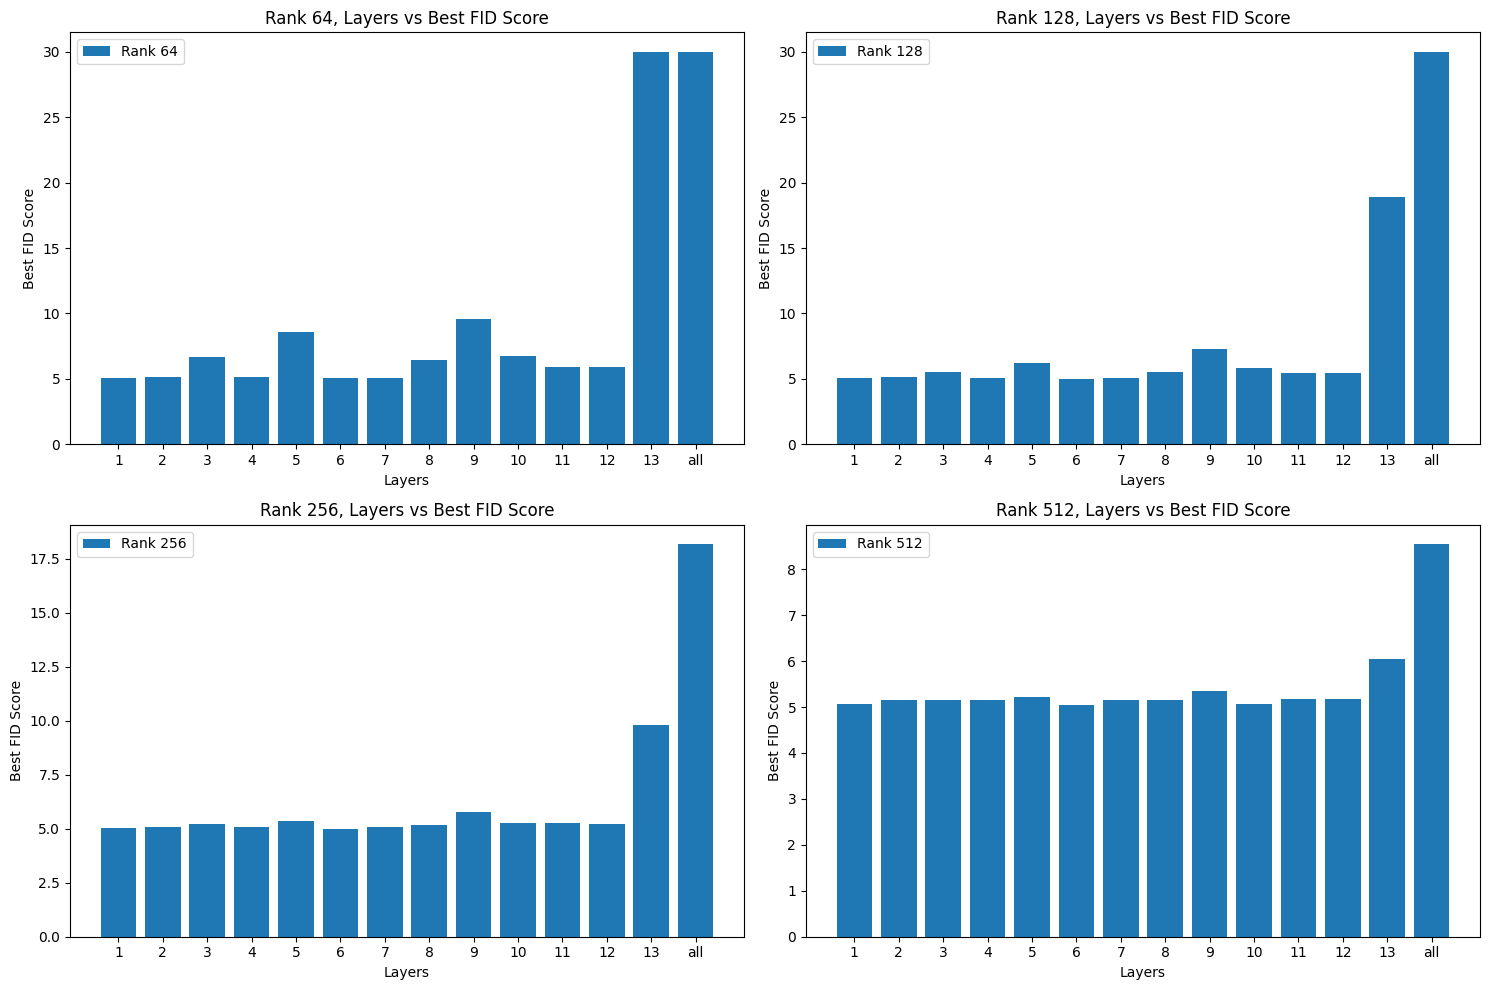

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Unique ranks in the DataFrame
df_sorted_plot = df_sorted
unique_ranks = df_sorted_plot['Rank'].unique()
df_sorted_plot['Best FID score'] = df_sorted_plot['Best FID score'].apply(lambda x: min(x, 30) if x > 30 else x)

# Setting up the figure for plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the array of axes for easy iteration

for i, rank in enumerate(sorted(unique_ranks)[:4]):  # Limiting to first 4 unique ranks for this example
    # Filter the DataFrame for the current rank
    
    rank_df = df_sorted_plot[df_sorted_plot['Rank'] == rank]
    
    # Sorting values by 'Layers' might not be necessary if df_sorted is already sorted by 'Layers',
    # but ensure that 'Layers' including 'all' are handled if you haven't sorted them previously
    # rank_df = rank_df.sort_values(by='Layers')  # This line is optional based on your sorting logic
    
    # Plotting
    axes[i].bar(rank_df['Layers'], rank_df['Best FID score'], label=f'Rank {rank}')
    axes[i].set_title(f'Rank {rank}, Layers vs Best FID Score')
    axes[i].set_xlabel('Layers')
    axes[i].set_ylabel('Best FID Score')
    axes[i].legend()

plt.tight_layout()
plt.show()


['exps\\compress_large\\compress_64_all_2024_03_15_07_28_35\\Log\\2024-03-15-07-28_train.log', 'exps\\compress_large\\compress_128_all_2024_03_15_07_41_38\\Log\\2024-03-15-07-41_train.log', 'exps\\compress_large\\compress_256_all_2024_03_15_09_44_13\\Log\\2024-03-15-09-44_train.log', 'exps\\compress_large\\compress_512_all_2024_03_15_14_15_10\\Log\\2024-03-15-14-15_train.log', 'exps\\compress_large\\compress_1024_all_2024_03_20_03_11_21\\Log\\2024-03-20-03-11_train.log']


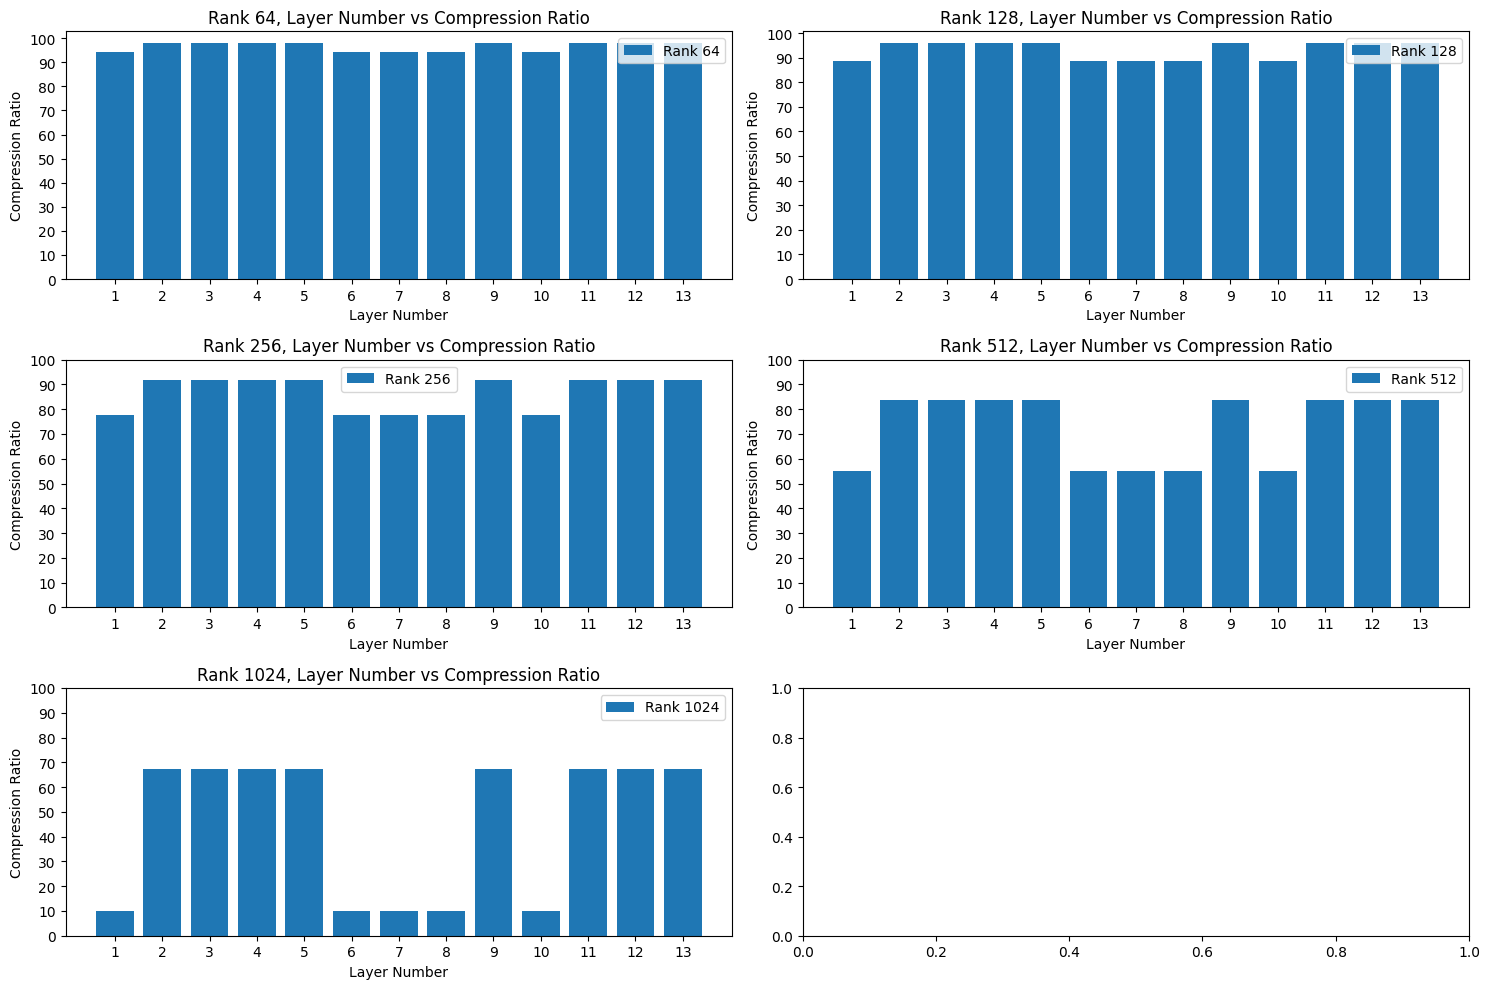

In [4]:
import os
import re

# Function to find all layer reduction ratio numbers with a specific pattern
def find_all_reduction_ratios(file_path, pattern):
    reduction_ratios = []
    try:
        with open(file_path, 'r') as f:  # Open the file in text mode
            # Iterate over each line in the file
            for line in f:
                line = line.strip()  # Remove leading/trailing whitespace
                # Use regex search to find matches
                match = re.search(pattern, line)
                # If a match is found, extract the number
                if match:
                    # The pattern includes a capturing group for the number
                    reduction_ratios.append(float(match.group(1)))
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    
    return reduction_ratios

def exp_namefromfile(file):
    parts = file.split('\\')
    exp_name = parts[-3]
    pattern = r"compress_(.*?)_all_\d{4}_\d{2}_\d{2}_\d{2}_\d{2}_\d{2}"
    # Search for the pattern and extract the group
    match = re.search(pattern, exp_name)
    if match:
        desired_part = match.group(1)  # The first capturing group matches your target
        return(desired_part.split('_'))
    else:
        return("Pattern not found")

# Keyword to search for in directory names
keyword = 'all'

# Find directories containing the keyword
directories = find_directories_with_keyword(base_directory, keyword)

# List all files within those directories
log_files = list_files_in_directories(directories)
# large
log_files = ['exps\\compress_large\\compress_64_all_2024_03_15_07_28_35\\Log\\2024-03-15-07-28_train.log', 'exps\\compress_large\\compress_128_all_2024_03_15_07_41_38\\Log\\2024-03-15-07-41_train.log', 'exps\\compress_large\\compress_256_all_2024_03_15_09_44_13\\Log\\2024-03-15-09-44_train.log', 'exps\\compress_large\\compress_512_all_2024_03_15_14_15_10\\Log\\2024-03-15-14-15_train.log', 'exps\\compress_large\\compress_1024_all_2024_03_20_03_11_21\\Log\\2024-03-20-03-11_train.log']

# small
# log_files = ['exps\\compress_small\\compress_64_all_2024_03_19_01_45_19\\Log\\2024-03-19-01-45_train.log', 'exps\\compress_small\\compress_128_all_2024_03_19_01_50_42\\Log\\2024-03-19-01-50_train.log', 'exps\\compress_small\\compress_256_all_2024_03_19_01_56_54\\Log\\2024-03-19-01-56_train.log', 'exps\\compress_small\\compress_512_all_2024_03_19_02_05_10\\Log\\2024-03-19-02-05_train.log']
print(log_files)

# List to store the results
results = []
regex = r"Layer Reduction ratio: (\d+\.\d+)"  # Regex pattern with a capturing group for the number

# Process each file
for file in log_files:
    last_line = find_all_reduction_ratios(file, regex)
    exp_name = exp_namefromfile(file)
    results.append([exp_name, last_line])
# print(results)


# Set up the figure for plotting
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.ravel()

# Iterate over each rank and its corresponding data
for i, (rank_info, compression_ratios) in enumerate(results):
    rank, ratios = rank_info[0], compression_ratios
    layers = list(range(1, 14))  # Layer numbers from 1 to 13
    
    # Plotting
    axes[i].bar(layers, ratios, label=f'Rank {rank}')
    axes[i].set_title(f'Rank {rank}, Layer Number vs Compression Ratio')
    axes[i].set_xlabel('Layer Number')
    axes[i].set_ylabel('Compression Ratio')
    axes[i].set_xticks(layers)  # Ensure each layer number is marked on the x-axis
    axes[i].set_yticks(range(0, 101, 10))  # Set y-axis ticks from 0 to 100 in steps of 10
    axes[i].legend()
    # axes[i].grid(True)  # Turn on the grid

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [5]:
excel_file_path = os.path.join(base_directory, 'sorted_scores.xlsx')
df_sorted = pd.read_excel(excel_file_path, sheet_name='Sorted Scores')

# Pivoting the DataFrame to have 'Rank' values as columns
pivot_df = df_sorted.pivot(index='Layers', columns='Rank', values='Best FID score')
pivot_df.columns = [f'Rank {col}' for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)

pivot_df['Layers_sort'] = pivot_df['Layers'].apply(lambda x: int(x) if x.isdigit() else 999)
pivot_df = pivot_df.sort_values(by=['Layers_sort'])
pivot_df = pivot_df.drop(columns=['Layers_sort'])

# List to store the results
results = []
regex = r"Layer Reduction ratio: (\d+\.\d+)"  # Regex pattern with a capturing group for the number

# Process each file
for file in log_files:
    last_line = find_all_reduction_ratios(file, regex)
    exp_name = exp_namefromfile(file)
    results.append([exp_name, last_line])
    
# Iterate over each rank and its corresponding data
for i, (rank_info, compression_ratios) in enumerate(results):
    updated_ratios = [(int(ratio)) for ratio in compression_ratios] + [0]
    pivot_df[f'CR % R={rank_info[0]}'] = updated_ratios # Compression Ratio
    
# Iterate over each rank and its corresponding data
for i, (rank_info, compression_ratios) in enumerate(results):
    # Inv_updated_ratios = [(100/int(ratio)) for ratio in compression_ratios] + [0]
    PenaltyRate = (1/2)
    Inv_updated_ratios = [1 + (1 - PenaltyRate*int(ratio)/100) for ratio in compression_ratios] + [0]
    pivot_df[f'FID/CR R={rank_info[0]}'] = Inv_updated_ratios*pivot_df[f'Rank {rank_info[0]}']

# Find the column name with the least value in each row
min_r_series = pivot_df.iloc[:, -5:].idxmin(axis=1)
min_r_numbers = min_r_series.apply(lambda x: int(x.split('=')[1]))
pivot_df['Best Rank'] = min_r_numbers

print(min_r_numbers[:-1].tolist())
print(pivot_df)

# Specify the path for the new Excel file
excel_file_path = os.path.join(base_directory,'compression_scores.xlsx')

# Write the sorted DataFrame to an Excel file
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    pivot_df.to_excel(writer, index=False, sheet_name='Sorted Scores')

excel_file_path
# os.startfile(excel_file_path)

[64, 256, 1024, 128, 1024, 256, 64, 1024, 1024, 1024, 1024, 1024, 1024]
   Layers  Rank 64  Rank 128  Rank 256  Rank 512  Rank 1024  CR % R=64  \
0       1     5.05      5.06      5.03      5.06       4.99         94   
5       2     5.17      5.12      5.10      5.16       5.12         97   
6       3     6.65      5.53      5.21      5.15       5.07         97   
7       4     5.13      5.09      5.10      5.16       5.13         97   
8       5     8.56      6.18      5.36      5.22       5.14         97   
9       6     5.07      5.02      5.00      5.05       4.96         94   
10      7     5.05      5.07      5.09      5.15       5.06         94   
11      8     6.41      5.53      5.16      5.15       5.02         94   
12      9     9.59      7.26      5.77      5.35       5.14         97   
1      10     6.78      5.84      5.27      5.06       4.94         94   
2      11     5.93      5.43      5.28      5.18       5.14         97   
3      12     5.92      5.41      5.20  

'exps\\compress_large\\compression_scores.xlsx'